In [19]:
# Import the necessary dependencies

# Operating System
import os

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, save_npz, load_npz

# Scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Model Evaluation
from evaluation import evaluate

# Submtion Evaluation
from validate_sample_submission import validate_submission

# 1: Import and exploratory analysis

#### BOOK RATING

In [20]:
#reading and analising book rating information

bookratings = pd.read_csv('data/BookRatings.csv')
print(bookratings.shape)
bookratings.head()

bookratings['Book-Rating'].value_counts(dropna=False) #from 1 to 10 and no missing values

bookratings['User-ID'].nunique() #5719
bookratings_users = bookratings['User-ID'].unique()

bookratings['ISBN'].nunique() #47768

bookratings[['User-ID','ISBN']].drop_duplicates() #there are no duplicates - 109209 rows × 2 columns

bookratings.head()

(109209, 3)


,User-ID,ISBN,Book-Rating
0,99,0316748641,7
1,99,0446677450,10
2,99,0553347594,9
3,99,0451166892,3
4,99,0671621009,10


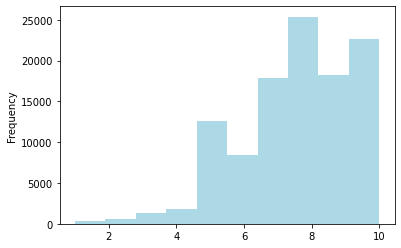

In [21]:
bookratings['Book-Rating'].plot.hist(color='lightblue')

#### TEST USERS

In [22]:
#reading and analising test users table

test_users = pd.read_csv('data/test_users.csv')
print(test_users.shape)

test_users['User-ID'].nunique() #there are no duplicates
test_users.head()

(589, 1)


,User-ID
0,114
1,507
2,850
3,3346
4,4092


In [23]:
# counting users that are already client and new prospects
test_users.isin(bookratings_users).sum(axis=0) #489

# list of clients with rating information
test_users_clients = test_users[test_users.isin(bookratings_users)].dropna().reset_index() #489

# list of new prospects
test_users_new = test_users[~test_users.isin(bookratings_users)].dropna().reset_index() #100
test_users_new

,index,User-ID
0,7,5490.0
1,11,8454.0
2,18,12569.0
3,28,15185.0
4,31,17003.0
...,...,...
95,566,272715.0
96,567,273190.0
97,571,274056.0
98,586,277901.0


#### BOOKS META INFO

In [24]:
booksmetainfo = pd.read_csv('data/BooksMetaInfo.csv')

booksmetainfo.shape #(112341, 12)
booksmetainfo.head(1)

/home/fernandamcohen/.virtualenvs/hckt05/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,authors,description,pageCount,categories
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,"['Mark P. O. Morford', 'Robert J. Lenardon']",Provides an introduction to classical myths pl...,808.0,['Social Science']


#### BOOKS USERS

,User-ID,Location,Age
0,2,"stockton, california, usa",18.0
1,8,"timmins, ontario, canada",NaN


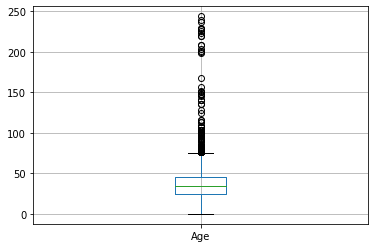

In [25]:
booksusers = pd.read_csv('data/BooksUsers.csv')
booksusers.shape #(61568, 3)

# booksusers['Age'].plot.hist(bins=20)
#NaN      24605

pd.DataFrame(booksusers.Age).boxplot();

booksusers.head(2)


In [26]:
booksusers.describe()

,User-ID,Age
count,61568.000000,36963.000000
mean,139536.404821,36.011146
std,80547.576351,14.865817
min,2.000000,0.000000
25%,69364.750000,25.000000
50%,139153.500000,34.000000
75%,209788.250000,45.000000
max,278854.000000,244.000000


# 2: Non-personalised recommendation

In [27]:
def make_ratings(data):
    """Creates the ratings matrix of listening history with optional shape
    
    Creates the ratings matrix from the listening history imported using the read_users_history() method.
    
    Args:
        data (pd.DataFrame):  Listening history for the users.
        shape (tuple): The overall (n_users, n_items) shape desired for the matrix. 
                       If None, define the shape with the (n_users, n_items) from data argument.
        
    Returns:
        ratings (csr_matrix): Ratings matrix with shape (n_users, n_items).
    
    """
    users, user_pos = np.unique(data.iloc[:, 0].values, return_inverse=True)
    items, item_pos = np.unique(data.iloc[:, 1].values, return_inverse=True)
    values = data.iloc[:, 2].fillna(0).values
    
    #R Matrix dimensions (n_users, n_items)
    shape = (len(users), len(items))

    R_ = csr_matrix((values, (user_pos, item_pos)), shape=shape)
    
    R_ = pd.DataFrame(data).pivot(index='User-ID', columns='ISBN', values="Book-Rating")
    
    return R_



def make_train_val_split(data, test_size = 0.2):
    """Split the data into train and validation and returns the ratings matrixes accordingly.
    
    Args:
        data (pd.DataFrame): Listening history for the users.
        test_size (float): Percentage of listening history used for validation.
    
    Returns:
        ratings_train (csr_matrix): Ratings matrix for train.
        ratings_val (csr_matrix): Ratings matrix for validation.
    
    """
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=8)

    #Store the indexes of each observation to identify which records to replace with zero
    train_index = train_data.index
    val_index = val_data.index

    #make copies of data to replace the observations
    train_data_clean = data.copy()
    val_data_clean = data.copy()

    #Replace the validation observations on the training data
    train_data_clean.loc[val_index,["Book-Rating"]] = 0
    
    #Replace the training observations on the validation data
    val_data_clean.loc[train_index,["Book-Rating"]] = 0

    #Create the R matrices
    R_train = make_ratings(train_data_clean)
    R_val = make_ratings(val_data_clean)

    #remove the explicit zeros from the sparse matrices
#     R_train.eliminate_zeros()
#     R_val.eliminate_zeros()

    return R_train, R_val


In [28]:
#creating traning and validation sets

test_size = 0.2

ratings_train, ratings_val = make_train_val_split(bookratings, test_size=test_size)

ratings_train.shape #(5719, 47768)
ratings_val.shape #(5719, 47768)


(5719, 47768)

In [29]:
type(ratings_train)

pandas.core.frame.DataFrame

### Average rating and quantity of rating per book

In [30]:
#rating average
avg_books = ratings_train[ratings_train>0].mean(axis=0).sort_values(ascending=False) #(47768,)

In [31]:
#ranting count
count_books = np.greater(ratings_train.fillna(0), 0).sum(axis=0)

ISBN
9997508769    10.0
0743247183    10.0
074342736X    10.0
0743424239    10.0
0743423712    10.0
              ... 
9838120014     NaN
9839154125     NaN
987906500X     NaN
9971400162     NaN
9997507002     NaN
Length: 47768, dtype: float64

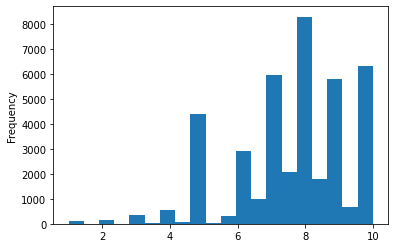

In [32]:
avg_books.shape
avg_books.plot.hist(bins=20);

#NaN          6817
#avg_books.value_counts(dropna=False)

avg_books

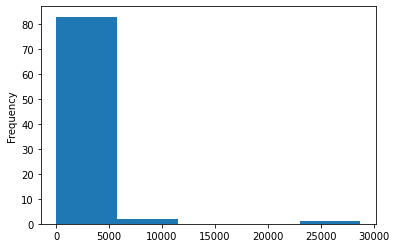

In [33]:
count_books.value_counts(dropna=False).plot.hist(bins=5);

In [34]:
non_pers_mean = pd.merge(pd.DataFrame(count_books, columns=['qtd']), pd.DataFrame(avg_books, columns=['avg']), on='ISBN').dropna()
#(40951, 2)

In [35]:
non_pers_mean_gt10 = non_pers_mean[non_pers_mean['qtd']>10].sort_values(by='avg', ascending=False) #(969, 2)

In [36]:
print(non_pers_mean_gt10.shape)
non_pers_mean_gt10.head()

(969, 2)


,qtd,avg
ISBN,,
0439425220,17,9.882353
0836218221,15,9.666667
0345339738,35,9.657143
006440188X,14,9.571429
0064409422,11,9.545455


### Select the 10 best rated for each user

#### 1 - new users

In [37]:
list_new_top10 = np.array(non_pers_mean[non_pers_mean['qtd']>50].sort_values(by='avg', ascending=False)[:10].index)
non_pers_mean[non_pers_mean['qtd']>50].sort_values(by='avg', ascending=False)[:10]
# type(list_new_top10)

,qtd,avg
ISBN,,
0439139597,70,9.228571
0446310786,85,9.094118
043935806X,97,9.092784
0590353403,61,9.016393
0345342968,63,9.000000
0439064864,68,8.985294
0439136369,53,8.981132
059035342X,118,8.966102
0345339681,62,8.822581


In [38]:
# type(test_users_new)
baseline_new = pd.DataFrame(test_users_new.copy())
baseline_new['chave']=1
baseline_new

list_new_top10_df = pd.DataFrame(list_new_top10, columns=['ISBN'])
list_new_top10_df['chave']=1
list_new_top10_df

# for i in list_new_top10:
#     baseline_new[i] = i
    
baseline_new = pd.merge(baseline_new,list_new_top10_df,on='chave', how='left').drop('chave',axis=1)
baseline_new

,index,User-ID,ISBN
0,7,5490.0,0439139597
1,7,5490.0,0446310786
2,7,5490.0,043935806X
3,7,5490.0,0590353403
4,7,5490.0,0345342968
...,...,...,...
995,587,278137.0,0439064864
996,587,278137.0,0439136369
997,587,278137.0,059035342X
998,587,278137.0,0345339681


#### 2 - clients

In [39]:
# I need create a list per user

list_clients = np.array(non_pers_mean[non_pers_mean['qtd']>10].sort_values(by='avg', ascending=False).index)
len(list_clients)

baseline_client = pd.DataFrame(columns=['User-ID','ISBN'])

for i in range(0,489):
    list_read = ratings_train.loc[test_users_clients.iloc[i][1]].dropna().index.to_list()
    
    pos_aux=0
    list_user = []
    while len(list_user) < 10:
        pos_aux=pos_aux+1
        
        if list_clients[pos_aux] not in list_read:
#             print(list_clients[pos_aux])
#             print(list_read)
            list_user.append(list_clients[pos_aux])
    
    
    aux_client = pd.DataFrame(pd.Series(test_users_clients.iloc[i][1]), columns=['User-ID'])
    aux_client['chave']=1

    list_top10_df = pd.DataFrame(list_user, columns=['ISBN'])
    list_top10_df['chave']=1
    
        
    aux_client = pd.merge(aux_client,list_top10_df,on='chave', how='left').drop('chave',axis=1)
    baseline_client = baseline_client.append(aux_client)        
        
        
    
# test_users_clients.iloc[0][1]



In [40]:
baseline_client.ISBN.nunique()

12

In [41]:
baseline = baseline_client.append(baseline_new)
baseline['User-ID']=baseline['User-ID'].map(int)

In [42]:
baseline.ISBN.nunique()#21
baseline['User-ID'].nunique()#589
baseline.head()

,User-ID,ISBN,index
0,114,0836218221,NaN
1,114,0345339738,NaN
2,114,006440188X,NaN
3,114,0064409422,NaN
4,114,0060256672,NaN


### Evaluation

### Export - 1st submission

In [234]:
validate_submission(baseline)

True

In [236]:
# baseline.to_csv('data/1st_submission.csv',index=False)

# 3: Personalised recommendation - Collaborative filtering

In [94]:
def make_ratings_2(data: pd.DataFrame) -> csr_matrix:
    """Creates the ratings matrix of listening history with optional shape
    
    Creates the ratings matrix from the listening history imported using the read_users_history() method.
    
    Args:
        data (pd.DataFrame):  Listening history for the users.
        shape (tuple): The overall (n_users, n_items) shape desired for the matrix. 
                       If None, define the shape with the (n_users, n_items) from data argument.
        
    Returns:
        ratings (csr_matrix): Ratings matrix with shape (n_users, n_items).
    
    """
    users, user_pos = np.unique(data.iloc[:, 0].values, return_inverse=True)
    items, item_pos = np.unique(data.iloc[:, 1].values, return_inverse=True)
    values = data.iloc[:, 2].fillna(0).values
    
    #R Matrix dimensions (n_users, n_items)
    shape = (len(users), len(items))

    R_ = csr_matrix((values, (user_pos, item_pos)), shape=shape)
    return R_, items, item_pos

def make_train_val_split_2(data: pd.DataFrame, test_size : float = 0.2):
    """Split the data into train and validation and returns the ratings matrixes accordingly.
    
    Args:
        data (pd.DataFrame): Listening history for the users.
        test_size (float): Percentage of listening history used for validation.
    
    Returns:
        ratings_train (csr_matrix): Ratings matrix for train.
        ratings_val (csr_matrix): Ratings matrix for validation.
    
    """
    train_data, val_data = train_test_split(data, test_size=test_size, random_state=8)

    #Store the indexes of each observation to identify which records to replace with zero
    train_index = train_data.index
    val_index = val_data.index

    #make copies of data to replace the observations
    train_data_clean = data.copy()
    val_data_clean = data.copy()

    #Replace the validation observations on the training data
    train_data_clean.loc[val_index,["rating"]] = 0
    
    #Replace the training observations on the validation data
    val_data_clean.loc[train_index,["rating"]] = 0

    #Create the R matrices
    R_train, items, item_pos = make_ratings_2(train_data_clean)
    R_val, itemsv, item_posv = make_ratings_2(val_data_clean)

    #remove the explicit zeros from the sparse matrices
    R_train.eliminate_zeros()
    R_val.eliminate_zeros()

    return R_train, R_val, items, item_pos


In [95]:
def make_user_similarities(R_: csr_matrix) -> csr_matrix:
    """Creates the user similarities matrix.
    
    Args:
        R_ (csr_matrix): Ratings matrix.
        
    Returns:
        user_similarities (csr_matrix): Matrix with user similarities.
    
    """
    return cosine_similarity(R_, dense_output=False)



ratings_train, ratings_val, items, item_pos = make_train_val_split_2(bookratings, test_size=test_size)

user_similarities = make_user_similarities(ratings_train)
user_similarities

<5719x5719 sparse matrix of type '<class 'numpy.float64'>'
	with 1122293 stored elements in Compressed Sparse Row format>

In [96]:
def make_user_predictions_collab_filt(S: csr_matrix, R_: csr_matrix):
    """Predict using collaborative filtering.
    
    Args:
        S (csr_matrix): Similarities matrix (tipically using the cosine_similarity).
        R_ (csr_matrix): Ratings matrix.
        
    Returns:
        preds (csr_matrix): Predictions matrix.
    
    """
    weighted_sum = np.dot(S, R_)
    
    # We use the absolute value to support negative similarities.
    # In this particular example there are none.
    sum_of_weights = np.abs(S).sum(axis=1)
    
    preds = weighted_sum / sum_of_weights
    
    # Exclude previously rated items.
    preds[R_.nonzero()] = 0
    
    return csr_matrix(preds)
 

collab_filt_user_preds = make_user_predictions_collab_filt(user_similarities, ratings_train)
collab_filt_user_preds

<5719x47768 sparse matrix of type '<class 'numpy.float64'>'
	with 46212022 stored elements in Compressed Sparse Row format>

In [97]:
def sparsity(matrix: csr_matrix) -> float:
    """Calculates the sparsity of a matrix.
    
    Args:
        matrix (csr_matrix): Sparse matrix.
        
    Returns:
        sparsity_ (float): Sparsity percentage (between 0 and 1).
    
    """
    return 1 - matrix.nnz / (matrix.shape[0] * matrix.shape[1])


sparsity(collab_filt_user_preds)

0.8308399453803484

In [50]:
def get_most_rated_from_user_preds(user_preds_: csr_matrix, n: int) -> np.matrix:
    """Returns the n most rated items from the user predictions.
    
    Args:
        user_preds_ (csr_matrix): A sparse ratings matrix
        n (int): The number of top-n items we should retrieve.
        
    Returns:
        most_rated (np.matrix): An array of the most rated items.
    
    """
    pred_ = np.negative(user_preds_).toarray()
    return pred_.argsort()[:, :n]


collab_filt_most_rated = get_most_rated_from_user_preds(collab_filt_user_preds, 10)
print(collab_filt_most_rated.shape)
collab_filt_most_rated

(5719, 10)


array([[ 7192, 14809,  1354, ..., 13320,  7837, 19677],
       [25510,  6976,  7192, ..., 16769,  2370, 40366],
       [ 7192,  3950,  5791, ..., 40366, 32475, 16425],
       ...,
       [25427,  5791, 17420, ..., 25296,  7953, 17714],
       [16030, 16148, 16034, ...,  8005, 30267, 12896],
       [41294, 17420, 23964, ..., 41377,  2406, 19960]])

In [170]:
# index-book
items, item_pos = np.unique(bookratings.iloc[:, 1].values, return_inverse=True)
depara_df= pd.DataFrame(pd.Series(item_pos), columns=['indices'])
depara_df['books'] = pd.Series(items[item_pos])
depara_df = depara_df.drop_duplicates()
depara_df

,indices,books
0,7216,0316748641
1,17954,0446677450
2,22851,0553347594
3,18751,0451166892
4,26117,0671621009
...,...,...
109194,29147,0689818904
109196,41628,1561580880
109197,15949,0435120425
109204,45001,1885071213


In [145]:
users, user_pos = np.unique(bookratings.iloc[:, 0].values, return_inverse=True)
users.shape

(5719,)

In [192]:
#associating prediction with users
collab_filt_most_rated_df = pd.DataFrame(collab_filt_most_rated,columns=[0,1,2,3,4,5,6,7,8,9],index=users)
collab_filt_most_rated_df

,0,1,2,3,4,5,6,7,8,9
99,7192,14809,1354,16745,33219,25509,16425,13320,7837,19677
114,25510,6976,7192,5791,16148,3950,8286,16769,2370,40366
243,7192,3950,5791,30267,19960,25296,23964,40366,32475,16425
244,7192,3950,7226,23964,5791,19960,30267,2198,11462,25296
254,16148,23964,7192,7226,17420,5791,7229,19960,32475,24801
...,...,...,...,...,...,...,...,...,...,...
278554,7192,23229,7896,12066,17420,11742,11462,46480,46338,46300
278582,6762,3950,5791,6746,6799,7192,40347,5952,16745,25509
278633,25427,5791,17420,23964,12896,3373,7192,25296,7953,17714
278843,16030,16148,16034,7192,5791,15995,13300,8005,30267,12896


In [193]:
# transforming index item position in the label of the book

for i in range(0,10):
    collab_filt_most_rated_df = pd.merge(collab_filt_most_rated_df, depara_df, how = 'left', left_on=i, right_on='indices')
    collab_filt_most_rated_df['r_'+str(i)] = collab_filt_most_rated_df['books']
    collab_filt_most_rated_df = collab_filt_most_rated_df.drop(['indices', 'books', i],axis=1)

collab_filt_most_rated_df

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9
0,0316666343,0399144463,0060938455,044023722X,0804106304,0671027360,044021145X,0385486804,0345339738,0451526341
1,0671027387,0312995423,0316666343,0312195516,043935806X,0142001740,0345417623,0440241073,0066214122,1400034779
2,0316666343,0142001740,0312195516,0743418174,0452282152,0671003755,059035342X,1400034779,0786868716,044021145X
3,0316666343,0142001740,0316769487,059035342X,0312195516,0452282152,0743418174,0064407667,0375707972,0671003755
4,043935806X,059035342X,0316666343,0316769487,0446310786,0312195516,0316776963,0452282152,0786868716,0618002243
...,...,...,...,...,...,...,...,...,...,...
5714,0316666343,0553571656,0345351525,0380729342,0446310786,0380002930,0375707972,3453196015,3442132096,342370747X
5715,0312966970,0142001740,0312195516,0312966091,0312971346,0316666343,1400031362,0312265867,044023722X,0671027360
5716,0671021001,0312195516,0446310786,059035342X,0385265700,0140293248,0316666343,0671003755,0345361792,0446532231
5717,0439136369,043935806X,0439139597,0316666343,0312195516,0439064864,0385484518,0345370775,0743418174,0385265700


In [201]:
collab_filt_most_rated_df = collab_filt_most_rated_df.set_index(users)
collab_filt_most_rated_df['User-ID']=users
collab_filt_most_rated_df

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,user,User-ID
99,0316666343,0399144463,0060938455,044023722X,0804106304,0671027360,044021145X,0385486804,0345339738,0451526341,99,99
114,0671027387,0312995423,0316666343,0312195516,043935806X,0142001740,0345417623,0440241073,0066214122,1400034779,114,114
243,0316666343,0142001740,0312195516,0743418174,0452282152,0671003755,059035342X,1400034779,0786868716,044021145X,243,243
244,0316666343,0142001740,0316769487,059035342X,0312195516,0452282152,0743418174,0064407667,0375707972,0671003755,244,244
254,043935806X,059035342X,0316666343,0316769487,0446310786,0312195516,0316776963,0452282152,0786868716,0618002243,254,254
...,...,...,...,...,...,...,...,...,...,...,...,...
278554,0316666343,0553571656,0345351525,0380729342,0446310786,0380002930,0375707972,3453196015,3442132096,342370747X,278554,278554
278582,0312966970,0142001740,0312195516,0312966091,0312971346,0316666343,1400031362,0312265867,044023722X,0671027360,278582,278582
278633,0671021001,0312195516,0446310786,059035342X,0385265700,0140293248,0316666343,0671003755,0345361792,0446532231,278633,278633
278843,0439136369,043935806X,0439139597,0316666343,0312195516,0439064864,0385484518,0345370775,0743418174,0385265700,278843,278843


In [194]:
# users, user_pos = np.unique(data.iloc[:, 0].values, return_inverse=True)
# items, item_pos = np.unique(data.iloc[:, 1].values, return_inverse=True)

# items, item_pos = np.unique(bookratings.iloc[:, 1].values, return_inverse=True)
# np.unique(bookratings.iloc[:, 1].values, return_inverse=True)
# items[item_pos]

In [229]:
#select users from test set with collaborative filtering predictions
test_users.isin(collab_filt_most_rated_df['User-ID'].unique()).sum(axis=0) #489

collab_filt_clients = collab_filt_most_rated_df[collab_filt_most_rated_df['User-ID'].isin(test_users_clients['User-ID'].tolist())]

collab_filt_clients= collab_filt_clients.drop(['user'],axis=1)
collab_filt_clients

,r_0,r_1,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,User-ID
114,0671027387,0312995423,0316666343,0312195516,043935806X,0142001740,0345417623,0440241073,0066214122,1400034779,114
507,0316666343,0553578693,1879181517,0375756140,0553585118,0553562738,0553242954,0312966970,0553584383,0425182878,507
850,0671578499,0380002930,0553296124,0756400082,0345413350,0671319590,0441644511,0425184129,0451456416,0441068812,850
3346,0316096199,0142001740,0312195516,0743418174,0671021001,0804106304,0671003755,0452282152,0345361792,0446310786,3346
4092,0812566645,0060392452,092007944X,0671721291,055328942X,0812551486,0441783589,0446310786,0380807343,0345333853,4092
...,...,...,...,...,...,...,...,...,...,...,...
276463,0763616052,0826412963,1400051428,0156007185,055358636X,0671885618,0679734821,0385484399,0813524660,0375410627,276463
276626,3499606607,3499606577,3548359310,3499606550,3442304172,0563362138,3462025244,3442443717,3503061150,3499505029,276626
276681,0316666343,0812550706,044023722X,0316776963,0805063889,0440219078,0446532231,0060392452,038079487X,0743418174,276681
276847,0001360469,0778320154,0778320243,0778320278,0778320286,0778320324,0778320359,0778320413,0778320502,0778320537,276847


In [241]:
collab_filt_clients.iloc[0][:10].tolist()
collab_filt_clients.iloc[i]['User-ID']
pd.DataFrame(collab_filt_clients.iloc[0][:10].tolist(), columns=['ISBN'])

,ISBN
0,0671027387
1,0312995423
2,0316666343
3,0312195516
4,043935806X
5,0142001740
6,0345417623
7,0440241073
8,0066214122
9,1400034779


In [242]:
collab_filt_clients_sub = pd.DataFrame(columns=['User-ID','ISBN'])

for i in range(0,489):
    list_predict = collab_filt_clients.iloc[i][:10].tolist()
    
    aux_client = pd.DataFrame(pd.Series(collab_filt_clients.iloc[i]['User-ID']), columns=['User-ID'])
    aux_client['chave']=1

    list_top10_df = pd.DataFrame(list_predict, columns=['ISBN'])
    list_top10_df['chave']=1
    
        
    aux_client = pd.merge(aux_client,list_top10_df,on='chave', how='left').drop('chave',axis=1)
    collab_filt_clients_sub = collab_filt_clients_sub.append(aux_client)
    
collab_filt_clients_sub

,User-ID,ISBN
0,114,0671027387
1,114,0312995423
2,114,0316666343
3,114,0312195516
4,114,043935806X
...,...,...
5,278633,0140293248
6,278633,0316666343
7,278633,0671003755
8,278633,0345361792


In [247]:
colab_version = collab_filt_clients_sub.append(baseline_new)
colab_version['User-ID']=colab_version['User-ID'].map(int)
colab_version=colab_version.drop('index',axis=1)

In [248]:
colab_version.ISBN.nunique()#1434
colab_version['User-ID'].nunique()#589
colab_version.head()

,User-ID,ISBN
0,114,0671027387
1,114,0312995423
2,114,0316666343
3,114,0312195516
4,114,043935806X


In [249]:
validate_submission(colab_version)

True

In [250]:
colab_version.to_csv('data/2nd_submission.csv',index=False)